In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta, timezone
import bz2
import json
import collections
from pprint import PrettyPrinter

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from intervaltree import IntervalTree, Interval
from iso8601 import parse_date

from satbazaar import db


pprint = PrettyPrinter().pprint


In [3]:
%%time
# script 'get-observations.py' generates this file
observations = json.load(bz2.open('data/observations.json.bz2'))

satellites = db.load_satellites('data/satellites.json', 'data/tle.sqlite')

CPU times: user 3.98 s, sys: 164 ms, total: 4.14 s
Wall time: 4.15 s


In [4]:
# construct histogram of observation count per satellite
# find earliest observation per sat for normalization
norad_hist = collections.defaultdict(int)

now = datetime.now(timezone.utc)
def recent():
    return now

norad_first = collections.defaultdict(recent)

for o in observations.values():
    norad = o['norad_cat_id']
    start = parse_date(o['start'])
    
    norad_hist[o['norad_cat_id']] += 1
    if start < norad_first[norad]:
        norad_first[norad] = start

In [5]:
# order dict by value
norad_hist = collections.OrderedDict(sorted(norad_hist.items(), key=lambda t: t[1], reverse=True))

# add known sats with no observations
for sat in satellites.values():
    norad = sat['norad_cat_id']
    if norad not in norad_hist:
        norad_hist[norad] = 0

In [6]:
norads, counts = zip(*norad_hist.items())

norad2name = {}
for norad, sat in satellites.items():
    norad2name[norad] = sat['name']

names = []
for i in norads:
    try:
        name = norad2name[i]
    except KeyError:
        print(i, 'missing')
        name = 'Unknown'
    names.append(name)


42737 missing
42702 missing
41895 missing
41474 missing
39436 missing
42770 missing
41931 missing
41478 missing
41909 missing
41934 missing
41477 missing
40949 missing
40948 missing
39381 missing
40897 missing


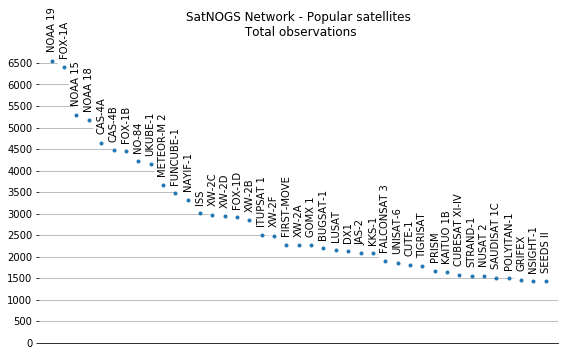

In [7]:
num_sats = 41
offset = 200

fig, ax = plt.subplots(figsize=(8,5))

x = list(range(len(names)))
lines = ax.plot(x[:num_sats], counts[:num_sats], '.')




# add satellite name data labels
for i, name, count in zip(x[:num_sats],
                          names[:num_sats],
                          counts[:num_sats]):
    ax.text(i, count+offset, name, rotation='vertical', ha='center', va='bottom')


# cleanup x axis junk
ax.set_xlim((-1, num_sats))
ax.set_xticks([])

# cleanup y axis
ax.set_yticks(range(0, 6500+1, 500))
ax.set_ylim((0, 7000))

# turn off borders
for pos in ('top', 'left', 'right'):
    ax.spines[pos].set_visible(False)

# construct a patch for clipping the gridlines
xy = list(zip(x, counts))
xy.insert(0, (-1, counts[0]))
xy.insert(0, (-1, 0))
xy.append((num_sats, 0))
path = mpl.path.Path(xy)
patch = mpl.patches.PathPatch(path, facecolor='none', edgecolor='none')

# add patch (necessary!) then clip grid lines
ax.add_patch(patch)
ax.grid(axis='y', clip_path=patch)

ax.set_title('SatNOGS Network - Popular satellites\n Total observations')

fig.tight_layout()
#fig.savefig('popular-sats-all.png', dpi=100)


In [8]:
# normalize to average obs/day
for norad in norad_hist.keys():
    start = norad_first[norad]
    days = (now - start).total_seconds() / (60*60*24)
    if days != 0:
        norad_hist[norad] /= days
    else:
        norad_hist[norad] = 0
    
norad_hist = collections.OrderedDict(sorted(norad_hist.items(), key=lambda t: t[1], reverse=True))

norads, counts = zip(*norad_hist.items())

norad2name = {}
for norad, sat in satellites.items():
    norad2name[norad] = sat['name']

names = []
for i in norads:
    try:
        name = norad2name[i]
    except KeyError:
        print(i, 'missing')
        name = 'Unknown'
    names.append(name)


42737 missing
42702 missing
41895 missing
41474 missing
42770 missing
39436 missing
41478 missing
41931 missing
41934 missing
41909 missing
41477 missing
40949 missing
39381 missing
40948 missing
40897 missing


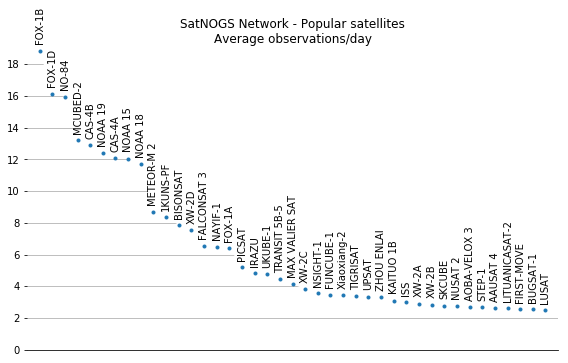

In [9]:
num_sats = 41
offset = 0.4

fig, ax = plt.subplots(figsize=(8,5))

x = list(range(len(names)))
lines = ax.plot(x[:num_sats], counts[:num_sats], '.')




# add satellite name data labels
for i, name, count in zip(x[:num_sats],
                          names[:num_sats],
                          counts[:num_sats]):
    ax.text(i, count+offset, name, rotation='vertical', ha='center', va='bottom')


# cleanup x axis junk
ax.set_xlim((-1, num_sats))
ax.set_xticks([])

# cleanup y axis
ax.set_yticks(range(0, 20, 2))
ax.set_ylim((0, 19))

# turn off borders
for pos in ('top', 'left', 'right'):
    ax.spines[pos].set_visible(False)

# construct a patch for clipping the gridlines
xy = list(zip(x, counts))
xy.insert(0, (-1, counts[0]))
xy.insert(0, (-1, 0))
xy.append((num_sats, 0))
path = mpl.path.Path(xy)
patch = mpl.patches.PathPatch(path, facecolor='none', edgecolor='none')

# add patch (necessary!) then clip grid lines
ax.add_patch(patch)
ax.grid(axis='y', clip_path=patch)

ax.set_title('SatNOGS Network - Popular satellites\nAverage observations/day')

fig.tight_layout()
#fig.savefig('popular-sats-avg.png', dpi=100)
